In [7]:
# Use Financial APIs:

import yfinance as yf

# Get historical stock data
stock_data = yf.download('AAPL', start='2010-01-01', end='2024-10-13')
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393281,447610800


In [8]:
#Pre-processing Data:

#Feature Engineering
#Adding a moving average feature
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()


In [9]:
#Scaling Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data[['Close']])


In [11]:
#Model Building

#Train a Time-Series Forecasting Model Using LSTM
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(scaled_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0373
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0018
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0011
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0010
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.0286e-04
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0010
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.8563e-04
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.0274e-04
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.4326e-04


In [5]:
model.save('lstm_model.h5')


In [13]:
from keras.models import load_model
model = load_model('lstm_model.h5')


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


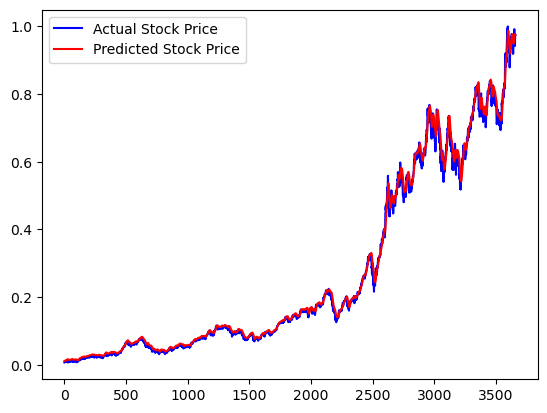

In [14]:
#Evaluate Model Performance For LSTM
import matplotlib.pyplot as plt

predictions = model.predict(X_train)
plt.plot(y_train, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.legend()
plt.show()


In [15]:
#Train a Time-Series Forecasting Model Using ARIMA
import pandas as pd

# Assuming the data is daily, and we start from a specific date (e.g., '2020-01-01')
date_range = pd.date_range(start='2020-01-01', periods=len(stock_data), freq='D')

# Set this date range as the index
stock_data.index = date_range

# Now fit the ARIMA model using the updated stock_data with the date index
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(stock_data['Close'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast the next 5 steps
forecast = model_fit.forecast(steps=5)

# Display forecasted values
print(forecast)

2030-03-08    227.469435
2030-03-09    227.600758
2030-03-10    227.678899
2030-03-11    227.656518
2030-03-12    227.633005
Freq: D, Name: predicted_mean, dtype: float64


In [16]:
import pickle

with open('arima_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)


In [17]:
with open('arima_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [18]:
#Evaluate Model Performance For ARIMA
# AIC score
model_fit.aic


14022.06196212988